In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks 
from tensorflow.keras import metrics
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import log_loss,accuracy_score, balanced_accuracy_score, precision_score, recall_score,f1_score, fbeta_score, make_scorer, roc_auc_score, roc_curve, confusion_matrix
from scikitplot.metrics import plot_confusion_matrix, plot_roc
#from tensorflow.keras.metrics import AUC, Recall, Precision
# load a saved model
from tensorflow.keras.models import load_model
import h5py
#from keras.layers.core import Dense, Flatten, Dropout

In [3]:
from tensorflow.keras.layers import Dense ,BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2, l1

In [5]:
data = pd.read_csv("/Users/serkankd/Documents/Master_Thesis/atp_data/atp_data_prepared.csv")

In [6]:
features = [
    'surface_Clay', 'surface_Grass','surface_Hard', 
    'tourney_level_ATP500','tourney_level_F', 'tourney_level_G', 'tourney_level_M', 
    'round_QF','round_R128', 'round_R16', 'round_R32', 'round_R64', 'round_RR','round_SF',
    'p1_hand_R', 'p1_hand_U', 'p2_hand_R', 'p2_hand_U',
    'rank_diff', 
    'rank_pts_diff',
    'aces', 'dfs', 'svpts', 'firstIns', 'firstWons', 'secondWons', 'SvGms',
    'bpSaveds', 'bpFaceds', 'firstServe_percs', 'secondIns',
    'firstSvptWons_perc', 'secondSvptWons_perc', 'firstReturnWons',
    'secondReturnWons', 'firstReturnWons_perc', 'secondReturnWons_perc',
    'bpWons_perc', 'bpWons', 'bpConverteds_perc', 'overallServes_perc',
    'overallReturnes_perc', 'completeness', 'serveAdv'
]

perf_features = [
    #'surface_Clay', 'surface_Grass','surface_Hard', 
    #'tourney_level', 
    #'round',
    #'p1_hand_R', 'p1_hand_U', 'p2_hand_R', 'p2_hand_U',
    'rank_diff', 
    'rank_pts_diff',
    'aces', 'dfs', 'svpts', 'firstIns', 'firstWons', 'secondWons', 'SvGms',
    'bpSaveds', 'bpFaceds', 'firstServe_percs', 'secondIns',
    'firstSvptWons_perc', 'secondSvptWons_perc', 'firstReturnWons',
    'secondReturnWons', 'firstReturnWons_perc', 'secondReturnWons_perc',
    'bpWons_perc', 'bpWons', 'bpConverteds_perc', 'overallServes_perc',
    'overallReturnes_perc', 'completeness', 'serveAdv'
]

## Data Splitting

In [7]:
# split dataset into train, validation and test sets using year.
mask_train = data.year <= 2013 
mask_val = (data.year >= 2014) & (data.year <= 2015)
#mask_train_val = data.year <= 2015
mask_test = data.year > 2015

In [8]:
data_train = data.loc[mask_train]
data_val = data.loc[mask_val]
#data_train_val = data.loc[mask_train_val]
data_test = data.loc[mask_test]
print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(37259, 115)
(4924, 115)
(2522, 115)


In [9]:
X_train = data_train[features].values
y_train = data_train.outcome.values

X_val = data_val[features].values
y_val = data_val.outcome.values

#X_train_val = data_val[features]
#y_train_val = data_val.outcome

X_test = data_test[features].values
y_test = data_test.outcome.values

print(f"Shape of train set is {X_train.shape}")
print(f"Shape of validation set is {X_val.shape}")
print(f"Shape of test set is {X_test.shape}")
print(f"Shape of train label is {y_train.shape}")
print(f"Shape of validation label is {y_val.shape}")
print(f"Shape of test labels is {y_test.shape}")

Shape of train set is (37259, 44)
Shape of validation set is (4924, 44)
Shape of test set is (2522, 44)
Shape of train label is (37259,)
Shape of validation label is (4924,)
Shape of test labels is (2522,)


### Outlier Detection and Removal

In [10]:
# identify outliers in the training dataset
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
yhat = lof.fit_predict(X_train)

In [11]:
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]
# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)

(33533, 44) (33533,)


In [12]:
X_train_num = data_train[perf_features].select_dtypes(include = ['float64', 'int64'])
X_train_num.head()

,rank_diff,rank_pts_diff,aces,dfs,svpts,firstIns,firstWons,secondWons,SvGms,bpSaveds,...,secondReturnWons,firstReturnWons_perc,secondReturnWons_perc,bpWons_perc,bpWons,bpConverteds_perc,overallServes_perc,overallReturnes_perc,completeness,serveAdv
0,1.176323,411.0,5.0,3.0,-16.0,-17.0,-7.0,2.0,1.0,-10.0,...,1.0,0.093666,0.027843,0.066667,1.0,0.066667,0.052670,0.052670,0.052670,-5.551115e-17
1,1.340491,204.0,-4.0,-2.0,-10.0,-11.0,-12.0,1.0,0.0,0.0,...,0.0,-0.172619,0.015152,-0.222222,-3.0,-0.222222,-0.085625,-0.085625,-0.085625,0.000000e+00
2,0.368782,87.0,2.0,-1.0,-19.0,-10.0,1.0,1.0,0.0,-6.0,...,10.0,0.229001,0.262443,-0.600000,4.0,0.400000,0.246823,0.246823,0.246823,0.000000e+00
3,0.171611,37.0,-4.0,0.0,-5.0,1.0,-8.0,3.0,0.0,-3.0,...,9.0,-0.153822,0.114412,-0.204545,-2.0,-0.204545,-0.019848,-0.019848,-0.019848,-5.551115e-17
4,0.584963,186.0,3.0,-3.0,3.0,-1.0,5.0,6.0,1.0,-2.0,...,2.0,0.207672,0.169336,0.500000,3.0,0.500000,0.185532,0.185532,0.185532,1.110223e-16


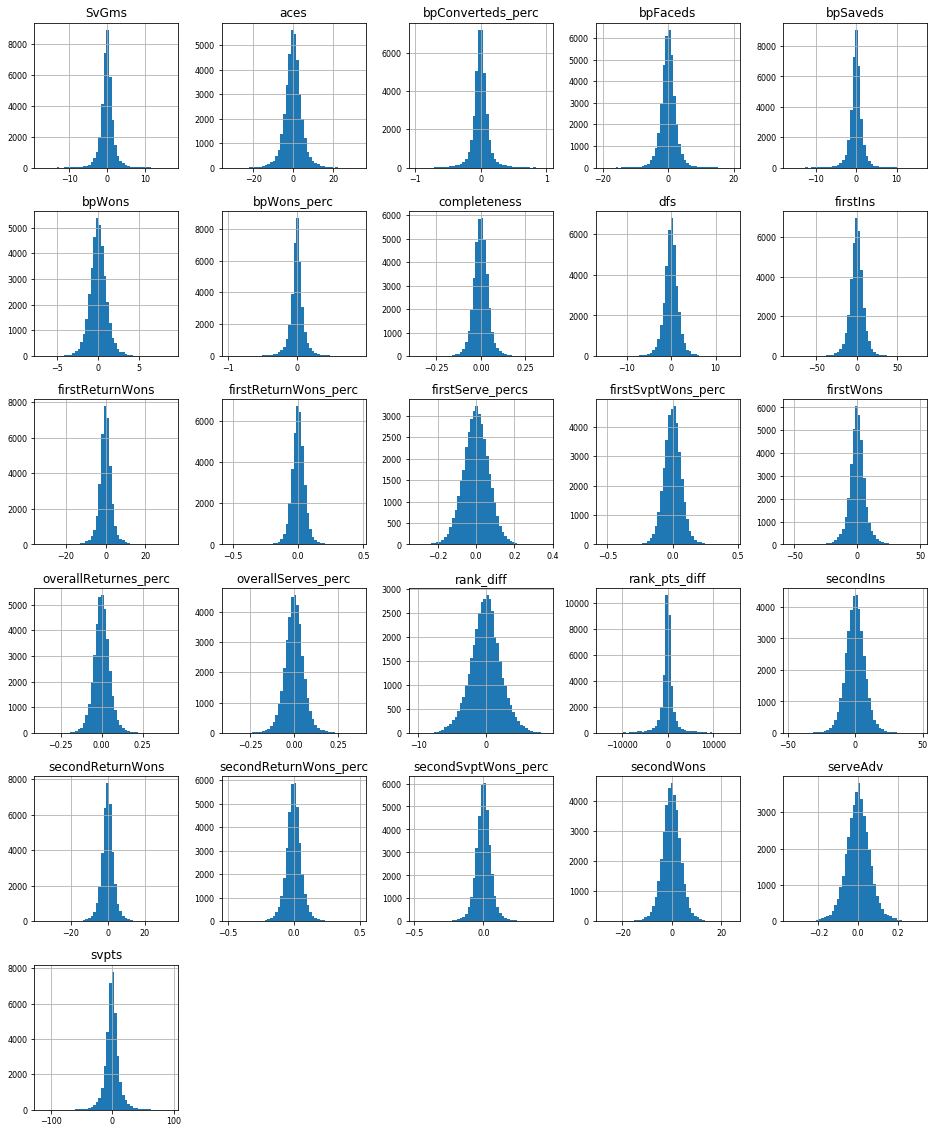

In [13]:
X_train_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);
# Thanks to symmetric feature representation, each variable has a normal distribution with 0 mean.

### Normalization

In [14]:
# Data needs to be scaled to a small range like 0 to 1 for the neural network to work well.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale both the training inputs and outputs
scaled_training = scaler.fit_transform(X_train)
scaled_validation = scaler.transform(X_val)
scaled_testing = scaler.transform(X_test)

print(f"Shape of scaled training set is {scaled_training.shape}")
print(f"Shape of scaled validation set is {scaled_validation.shape}")
print(f"Shape of scaled test set is {scaled_testing.shape}")

Shape of scaled training set is (33533, 44)
Shape of scaled validation set is (4924, 44)
Shape of scaled test set is (2522, 44)


In [15]:
size_train = len(y_train)
ones_train = np.sum(y_train)
perc_ones_train = ones_train/size_train

size_val = len(y_val)
ones_val = np.sum(y_val)
perc_ones_val = ones_val/size_val

size_test = len(y_test)
ones_test = np.sum(y_test)
perc_ones_test = ones_test/size_test

print('Sample Size of trained data: %i, Percentage of winners in the target: %.3f' % (size_train, perc_ones_train))
print('Sample Size of validation data: %i, Percentage of winners in the target: %.3f' % (size_val, perc_ones_val))
print('Sample Size of test data: %i, Percentage of winners in the target: %.3f' % (size_test, perc_ones_test))

Sample Size of trained data: 33533, Percentage of winners in the target: 0.501
Sample Size of validation data: 4924, Percentage of winners in the target: 0.507
Sample Size of test data: 2522, Percentage of winners in the target: 0.506


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
Training Accuracy: 0.713, Validation Accuracy: 0.724


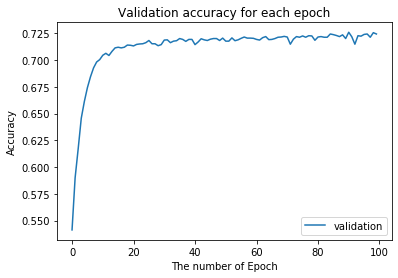

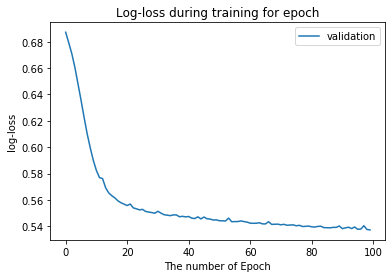

In [16]:
# Choose number of hidden units by trying different values
# Volatility increases but the performance remains stable after 10 units. Therefore, 10 is chosen.
# The optimizer is chosen by trying different values with different learning rate combinations
# Adam performs much better than the other optimizers. 
# When Adam is used, the model diverge if learning rate is greater than or equal to 0.1 but performs poorlz if it is less than or equal to 0.0001.
# Therefore, learning rate is chosen as 0.001
# Default values for Dropout, Regularization, and initializers performs faster and relatively same/better.
model = Sequential()
model.add(Dense(10, input_dim=44, activation='relu',
                   #kernel_initializer=initializers.RandomNormal(stddev=0.01),
                    #bias_initializer=initializers.Zeros(),
                   #kernel_regularizer=l2(0.01)
               ))
#model.add(Dropout(0.5))
#model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#opt = SGD(lr=0.001)
#opt = SGD(lr=0.001, momentum = 0.1)
#opt = RMSprop(lr=0.001)
#opt = keras.optimizers.Adam(lr=0.001)
opt = Adam(lr=1e-3)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) # we can use accuracy since outcome is balanced

# simple early stopping
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
#mc = ModelCheckpoint(filepath="/Users/serkankd/Documents/Master Thesis/best_model.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
history = model.fit(scaled_training, y_train, validation_data=(scaled_validation, y_val), epochs=100, verbose=0, batch_size = 1028)
#history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=0)
# list all data in history
print(history.history.keys())
# evaluate the model
_, train_acc = model.evaluate(scaled_training, y_train, verbose=0)
_, val_acc = model.evaluate(scaled_validation, y_val, verbose=0)
print('Training Accuracy: %.3f, Validation Accuracy: %.3f' % (train_acc, val_acc))

# Make a prediction with the neural network
prediction_probs = model.predict_proba(scaled_testing)
prediction = model.predict(scaled_testing)
y_pred = np.where(prediction >= 0.5, 1, 0).astype(np.int_)

# plot training history accuracy
#plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.title("Validation accuracy for each epoch")
plt.xlabel("The number of Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# plot training history loss
#plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title("Log-loss during training for epoch")
plt.xlabel("The number of Epoch")
plt.ylabel("log-loss")
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import classification_report
target_names = ['Player 1 lost', 'Player 1 won']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.72      0.70      0.71      1247
     class 1       0.71      0.73      0.72      1275

    accuracy                           0.72      2522
   macro avg       0.72      0.72      0.72      2522
weighted avg       0.72      0.72      0.72      2522



In [18]:
loss = log_loss(y_test, prediction)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('Log-loss: %.3f' % loss)
print('Recall: %.3f' % recall)
print('Precision: %.3f' % precision)
print('F1-score: %.3f' % f1)

Log-loss: 0.556
Recall: 0.733
Precision: 0.713
F1-score: 0.723


No Skill: ROC AUC=0.500
2-Layer Neural Network: ROC AUC=0.787


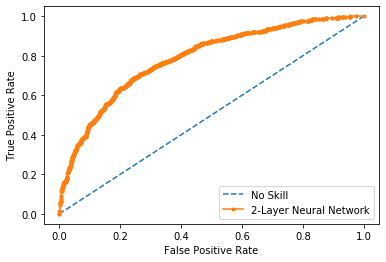

In [20]:
y_test = y_test.reshape((2522,1)).astype(np.int_)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
nn_auc = roc_auc_score(y_test, prediction_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('2-Layer Neural Network: ROC AUC=%.3f' % (nn_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, prediction_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(nn_fpr, nn_tpr, marker='.', label='2-Layer Neural Network')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Confusion matrix, without normalization
[[870 377]
 [340 935]]


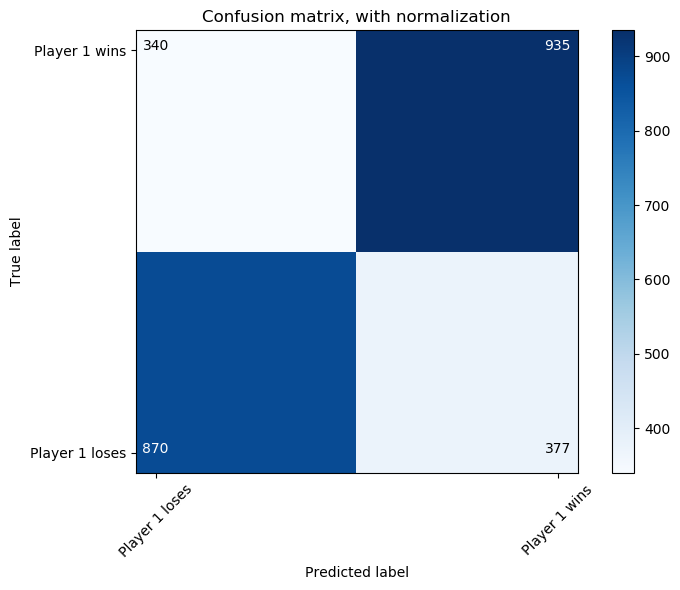

In [21]:
import itertools
from itertools import *
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6), dpi=100)
plt.axis('scaled')
plot_confusion_matrix(cnf_matrix, classes=['Player 1 lost','Player 1 won'],
                      title='Confusion matrix, with normalization')

Confusion matrix, without normalization
[[870 377]
 [340 935]]


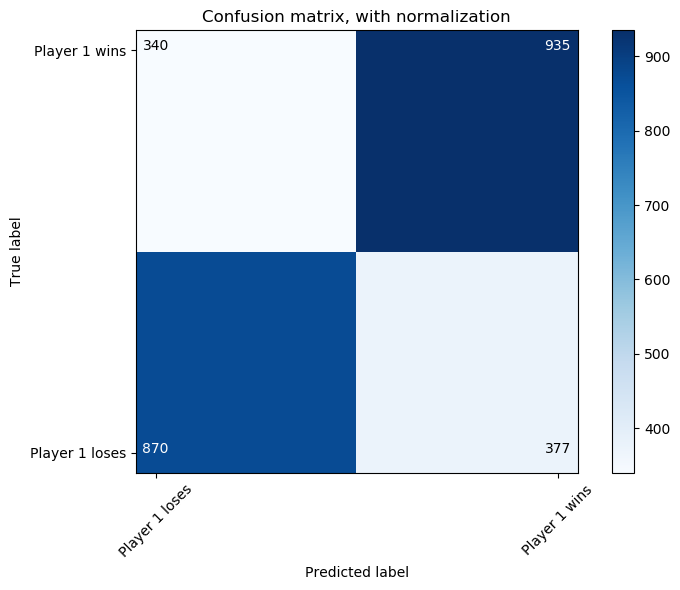

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6), dpi=100)
plt.axis('scaled')
plot_confusion_matrix(cnf_matrix, classes=['Player 1 loses','Player 1 wins'],
                      title='Confusion matrix, with normalization')